## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [1]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
%matplotlib qt

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)

This image is distorted


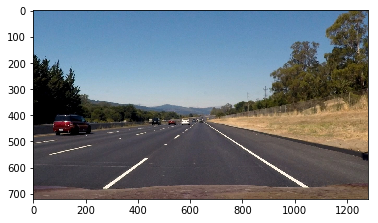

In [28]:
#image = cv2.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/straight_lines2.jpg')
image123 = mpimg.imread('test_images/test5.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
print('\nThis image is distorted')

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


These images are undistorted


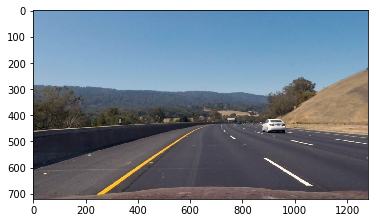

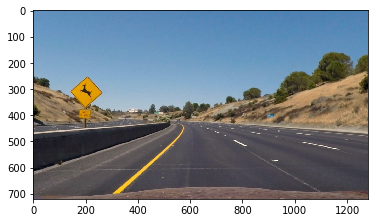

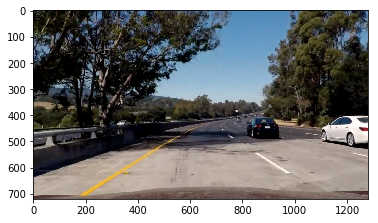

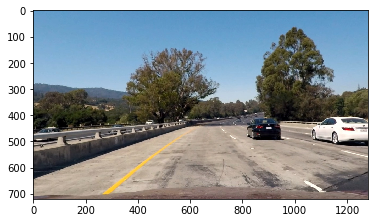

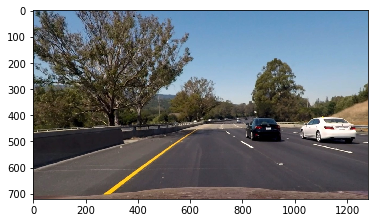

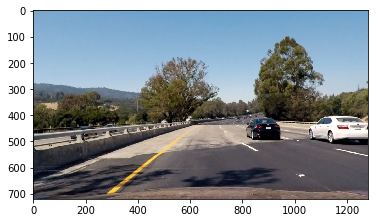

In [4]:
undist_array = []

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

test_images = glob.glob('test_images/test*.jpg')
#test_images_straight = glob.glob('test_images/straight_lines*.jpg')

#undistorted = cal_undistort(image, objpoints, imgpoints)

for fname in test_images:
    image1 = mpimg.imread(fname)
    undistorted = cal_undistort(image1, objpoints, imgpoints)
    undist_array.append(undistorted)
    plt.figure()
    plt.imshow(undistorted)

print('\nThese images are undistorted')

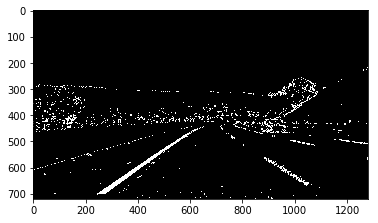

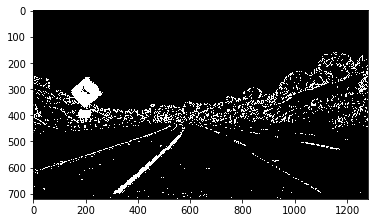

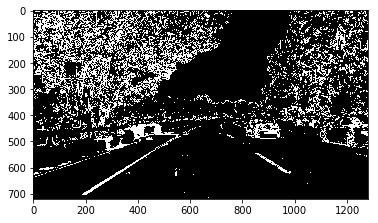

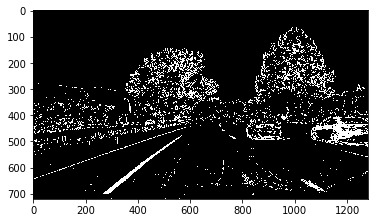

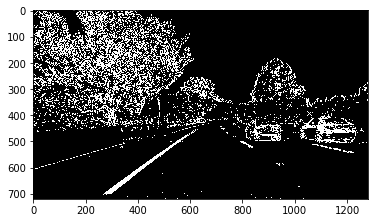

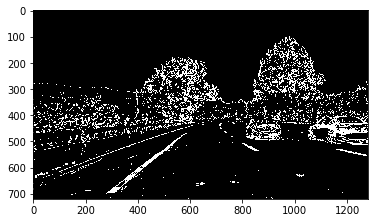

In [57]:
binary_image_array = []

for image in undist_array:
    #image = undistorted
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    binary_image_array.append(combined_binary)
    plt.figure()
    plt.imshow(combined_binary, cmap='gray')


In [58]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

img_size = (image.shape[1], image.shape[0])

src = np.float32([[590,450],[687,450],[1100,720],[200,720]])

dst = np.float32([[300,0],[900,0],[900,720],[300,720]])

M = cv2.getPerspectiveTransform(src, dst)

M_inverse = cv2.getPerspectiveTransform(dst, src)

In [59]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

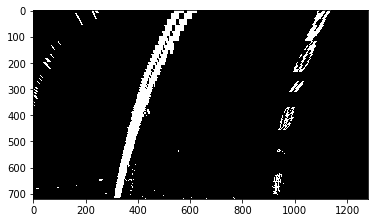

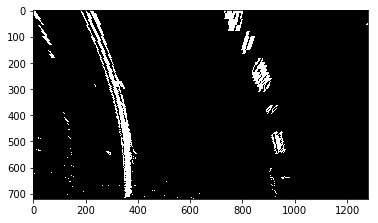

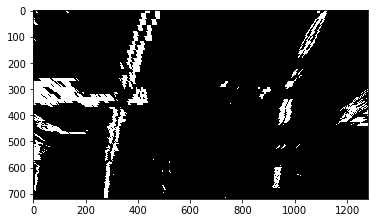

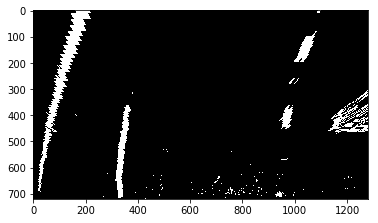

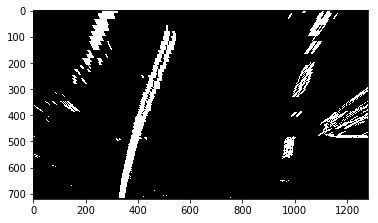

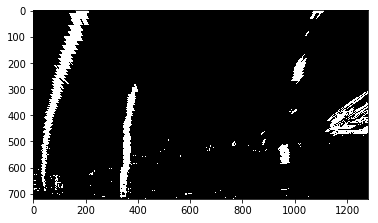

In [60]:
binary_warped_images = []
for img in binary_image_array:
    warped_image = warper(img, src, dst)
    #warped_image_gray = cv2.cvtColor(warped_image,cv2.COLOR_BGR2GRAY)
    plt.figure()
    plt.imshow(warped_image, cmap='gray')
    binary_warped_images.append(warped_image)

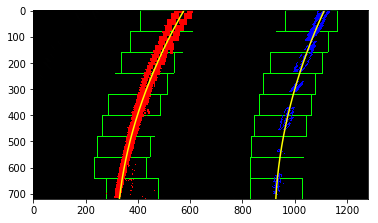

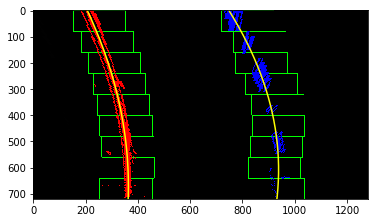

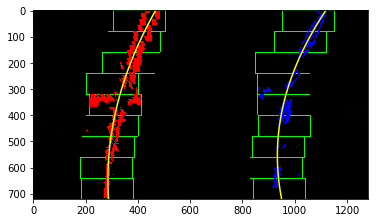

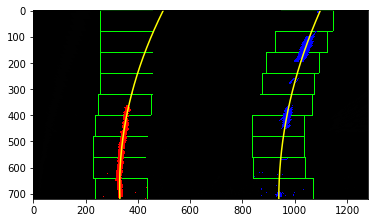

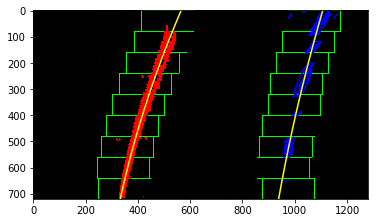

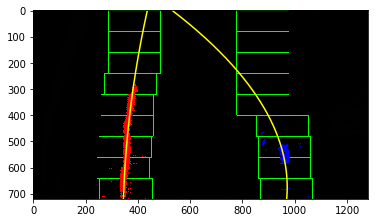

In [61]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


#out_img = fit_polynomial(binary_warped_images[0])
#plt.imshow(out_img)
for img in binary_warped_images:
    result = fit_polynomial(img)
    plt.imshow(result)
    plt.figure()

In [62]:
def measure_radius_of_curvature(x_values, binary_warped):
    num_rows = binary_warped.shape[0]
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

Radius of curvature: 701.76 m
Center offset: 0.08 m
Radius of curvature: 364.64 m
Center offset: 0.00 m
Radius of curvature: 1168.94 m
Center offset: 0.20 m
Radius of curvature: 489.31 m
Center offset: 0.01 m
Radius of curvature: 1297.50 m
Center offset: 0.01 m
Radius of curvature: 1026.55 m
Center offset: 0.03 m


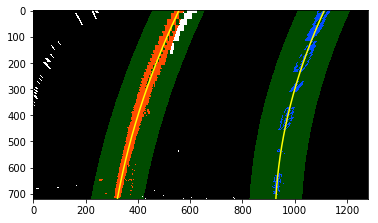

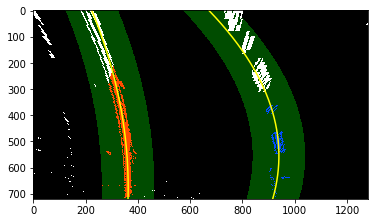

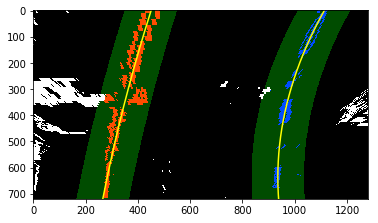

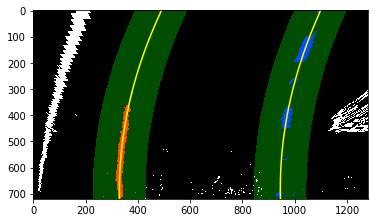

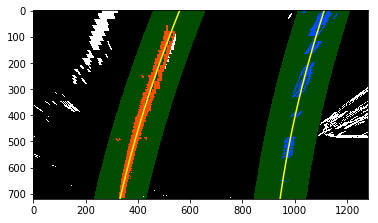

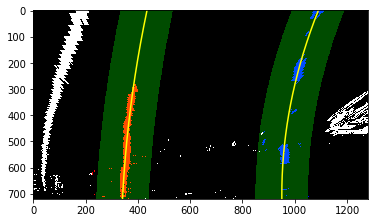

In [63]:
final_lane_images = []

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    left_curve_radius = measure_radius_of_curvature(left_fitx, binary_warped)
    right_curve_radius = measure_radius_of_curvature(right_fitx, binary_warped)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_radius
    print(curvature_string)
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_size[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Center offset: %.2f m" % center_offset_meters
    print(offset)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
for image in binary_warped_images:
    result = search_around_poly(image)
    final_lane_images.append(result)
    plt.imshow(result)
    plt.figure()
    

In [64]:
def radius_and_offset(image):
    margin = 100
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(image.shape, leftx, lefty, rightx, righty)
    
    left_curve_radius = measure_radius_of_curvature(left_fitx, image)
    right_curve_radius = measure_radius_of_curvature(right_fitx, image)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_radius
    #print(curvature_string)
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_size[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Center offset: %.2f m" % center_offset_meters
    #print(offset)
    return curvature_string, offset

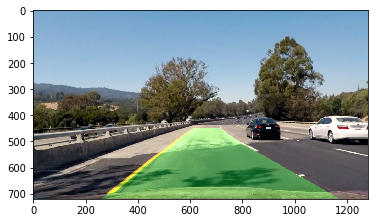

In [65]:
for image in binary_warped_images:
    
    margin = 100
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(image.shape, leftx, lefty, rightx, righty)
    
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inverse, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    

In [66]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

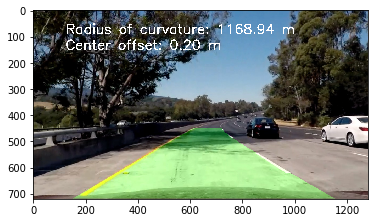

In [67]:
def process_image(image):
    # TODO: put your pipeline here
    initial_image = np.copy(image)
    undistorted = cal_undistort(initial_image, objpoints, imgpoints)
    #gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    warped_image = warper(combined_binary, src, dst)
    #result = fit_polynomial(warped_image)
    #result = search_around_poly(warped_image)
    curvature_string, offset = radius_and_offset(warped_image)
    #print(curvature_string)
    #print(offset)
    margin = 100
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, leftx, lefty, rightx, righty)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, M_inverse, img_size) 
    result_final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(result_final,curvature_string , (125, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=4)
    cv2.putText(result_final, offset, (125, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=4)
    return result_final

result_image = process_image(image123)
plt.imshow(result_image, cmap='gray')

In [68]:
white_output = 'test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<16:44,  1.25it/s]

  0%|          | 2/1261 [00:01<16:48,  1.25it/s]

  0%|          | 3/1261 [00:02<16:45,  1.25it/s]

  0%|          | 4/1261 [00:03<16:43,  1.25it/s]

  0%|          | 5/1261 [00:04<16:45,  1.25it/s]

  0%|          | 6/1261 [00:04<16:47,  1.25it/s]

  1%|          | 7/1261 [00:05<16:43,  1.25it/s]

  1%|          | 8/1261 [00:06<16:39,  1.25it/s]

  1%|          | 9/1261 [00:07<16:39,  1.25it/s]

  1%|          | 10/1261 [00:08<16:37,  1.25it/s]

  1%|          | 11/1261 [00:08<16:37,  1.25it/s]

  1%|          | 12/1261 [00:09<16:32,  1.26it/s]

  1%|          | 13/1261 [00:10<16:31,  1.26it/s]

  1%|          | 14/1261 [00:11<16:32,  1.26it/s]

  1%|          | 15/1261 [00:11<16:31,  1.26it/s]

  1%|▏         | 16/1261 [00:12<16:34,  1.25it/s]

  1%|▏         | 17/1261 [00:13<16:32,  1.25it/s]

  1%|▏         | 18/1261 [00:14<16:35,  1.25it/s]

  2%|▏         | 19/1261 [00:15<16:43,  1.24it/

 11%|█▏        | 143/1261 [02:01<18:47,  1.01s/it]

 11%|█▏        | 144/1261 [02:02<19:02,  1.02s/it]

 11%|█▏        | 145/1261 [02:03<18:32,  1.00it/s]

 12%|█▏        | 146/1261 [02:04<17:29,  1.06it/s]

 12%|█▏        | 147/1261 [02:05<16:45,  1.11it/s]

 12%|█▏        | 148/1261 [02:06<17:07,  1.08it/s]

 12%|█▏        | 149/1261 [02:07<16:33,  1.12it/s]

 12%|█▏        | 150/1261 [02:08<16:11,  1.14it/s]

 12%|█▏        | 151/1261 [02:08<15:48,  1.17it/s]

 12%|█▏        | 152/1261 [02:09<15:33,  1.19it/s]

 12%|█▏        | 153/1261 [02:10<15:26,  1.20it/s]

 12%|█▏        | 154/1261 [02:11<15:14,  1.21it/s]

 12%|█▏        | 155/1261 [02:12<15:03,  1.22it/s]

 12%|█▏        | 156/1261 [02:12<14:55,  1.23it/s]

 12%|█▏        | 157/1261 [02:13<15:04,  1.22it/s]

 13%|█▎        | 158/1261 [02:14<15:35,  1.18it/s]

 13%|█▎        | 159/1261 [02:15<16:30,  1.11it/s]

 13%|█▎        | 160/1261 [02:16<17:01,  1.08it/s]

 13%|█▎        | 161/1261 [02:17<17:30,  1.05it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [04:05<13:28,  1.21it/s]

 23%|██▎       | 285/1261 [04:05<13:27,  1.21it/s]

 23%|██▎       | 286/1261 [04:06<13:22,  1.22it/s]

 23%|██▎       | 287/1261 [04:07<13:13,  1.23it/s]

 23%|██▎       | 288/1261 [04:08<13:10,  1.23it/s]

 23%|██▎       | 289/1261 [04:09<13:15,  1.22it/s]

 23%|██▎       | 290/1261 [04:09<13:13,  1.22it/s]

 23%|██▎       | 291/1261 [04:10<13:11,  1.23it/s]

 23%|██▎       | 292/1261 [04:11<13:12,  1.22it/s]

 23%|██▎       | 293/1261 [04:12<13:10,  1.22it/s]

 23%|██▎       | 294/1261 [04:13<13:05,  1.23it/s]

 23%|██▎       | 295/1261 [04:13<13:05,  1.23it/s]

 23%|██▎       | 296/1261 [04:14<13:15,  1.21it/s]

 24%|██▎       | 297/1261 [04:15<13:32,  1.19it/s]

 24%|██▎       | 298/1261 [04:16<13:25,  1.19it/s]

 24%|██▎       | 299/1261 [04:17<13:14,  1.21it/s]

 24%|██▍       | 300/1261 [04:18<13:04,  1.22it/s]

 24%|██▍       | 301/1261 [04:18<12:59,  1.23it/s]

 24%|██▍       | 302/1261 [04:19<13:07,  1.22it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [06:01<11:29,  1.21it/s]

 34%|███▍      | 426/1261 [06:02<11:30,  1.21it/s]

 34%|███▍      | 427/1261 [06:03<11:29,  1.21it/s]

 34%|███▍      | 428/1261 [06:03<11:27,  1.21it/s]

 34%|███▍      | 429/1261 [06:04<11:26,  1.21it/s]

 34%|███▍      | 430/1261 [06:05<11:24,  1.21it/s]

 34%|███▍      | 431/1261 [06:06<11:23,  1.21it/s]

 34%|███▍      | 432/1261 [06:07<11:22,  1.21it/s]

 34%|███▍      | 433/1261 [06:08<11:15,  1.23it/s]

 34%|███▍      | 434/1261 [06:08<11:21,  1.21it/s]

 34%|███▍      | 435/1261 [06:09<11:13,  1.23it/s]

 35%|███▍      | 436/1261 [06:10<11:10,  1.23it/s]

 35%|███▍      | 437/1261 [06:11<11:27,  1.20it/s]

 35%|███▍      | 438/1261 [06:12<11:26,  1.20it/s]

 35%|███▍      | 439/1261 [06:13<11:19,  1.21it/s]

 35%|███▍      | 440/1261 [06:13<11:12,  1.22it/s]

 35%|███▍      | 441/1261 [06:14<11:09,  1.22it/s]

 35%|███▌      | 442/1261 [06:15<11:10,  1.22it/s]

 35%|███▌      | 443/1261 [06:16<11:07,  1.23it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [08:00<09:30,  1.22it/s]

 45%|████▍     | 567/1261 [08:01<09:30,  1.22it/s]

 45%|████▌     | 568/1261 [08:01<09:35,  1.20it/s]

 45%|████▌     | 569/1261 [08:02<09:34,  1.21it/s]

 45%|████▌     | 570/1261 [08:03<09:33,  1.21it/s]

 45%|████▌     | 571/1261 [08:04<09:31,  1.21it/s]

 45%|████▌     | 572/1261 [08:05<09:40,  1.19it/s]

 45%|████▌     | 573/1261 [08:06<09:39,  1.19it/s]

 46%|████▌     | 574/1261 [08:06<09:33,  1.20it/s]

 46%|████▌     | 575/1261 [08:07<09:28,  1.21it/s]

 46%|████▌     | 576/1261 [08:08<09:32,  1.20it/s]

 46%|████▌     | 577/1261 [08:09<09:30,  1.20it/s]

 46%|████▌     | 578/1261 [08:10<09:26,  1.20it/s]

 46%|████▌     | 579/1261 [08:11<09:24,  1.21it/s]

 46%|████▌     | 580/1261 [08:11<09:24,  1.21it/s]

 46%|████▌     | 581/1261 [08:12<09:23,  1.21it/s]

 46%|████▌     | 582/1261 [08:13<09:16,  1.22it/s]

 46%|████▌     | 583/1261 [08:14<09:18,  1.21it/s]

 46%|████▋     | 584/1261 [08:15<09:18,  1.21it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [09:58<07:50,  1.18it/s]

 56%|█████▌    | 708/1261 [09:59<07:51,  1.17it/s]

 56%|█████▌    | 709/1261 [10:00<07:50,  1.17it/s]

 56%|█████▋    | 710/1261 [10:01<08:00,  1.15it/s]

 56%|█████▋    | 711/1261 [10:01<07:57,  1.15it/s]

 56%|█████▋    | 712/1261 [10:02<07:57,  1.15it/s]

 57%|█████▋    | 713/1261 [10:03<07:58,  1.14it/s]

 57%|█████▋    | 714/1261 [10:04<07:53,  1.15it/s]

 57%|█████▋    | 715/1261 [10:05<07:53,  1.15it/s]

 57%|█████▋    | 716/1261 [10:06<07:52,  1.15it/s]

 57%|█████▋    | 717/1261 [10:07<07:49,  1.16it/s]

 57%|█████▋    | 718/1261 [10:07<07:40,  1.18it/s]

 57%|█████▋    | 719/1261 [10:08<07:33,  1.19it/s]

 57%|█████▋    | 720/1261 [10:09<07:30,  1.20it/s]

 57%|█████▋    | 721/1261 [10:10<07:48,  1.15it/s]

 57%|█████▋    | 722/1261 [10:11<07:57,  1.13it/s]

 57%|█████▋    | 723/1261 [10:12<07:54,  1.13it/s]

 57%|█████▋    | 724/1261 [10:13<07:46,  1.15it/s]

 57%|█████▋    | 725/1261 [10:14<07:34,  1.18it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [11:57<05:49,  1.18it/s]

 67%|██████▋   | 849/1261 [11:58<05:44,  1.20it/s]

 67%|██████▋   | 850/1261 [11:58<05:43,  1.20it/s]

 67%|██████▋   | 851/1261 [11:59<05:41,  1.20it/s]

 68%|██████▊   | 852/1261 [12:00<05:36,  1.21it/s]

 68%|██████▊   | 853/1261 [12:01<05:36,  1.21it/s]

 68%|██████▊   | 854/1261 [12:02<05:39,  1.20it/s]

 68%|██████▊   | 855/1261 [12:03<05:37,  1.20it/s]

 68%|██████▊   | 856/1261 [12:03<05:35,  1.21it/s]

 68%|██████▊   | 857/1261 [12:04<05:33,  1.21it/s]

 68%|██████▊   | 858/1261 [12:05<05:31,  1.22it/s]

 68%|██████▊   | 859/1261 [12:06<05:28,  1.22it/s]

 68%|██████▊   | 860/1261 [12:07<05:28,  1.22it/s]

 68%|██████▊   | 861/1261 [12:07<05:31,  1.21it/s]

 68%|██████▊   | 862/1261 [12:08<05:35,  1.19it/s]

 68%|██████▊   | 863/1261 [12:09<05:32,  1.20it/s]

 69%|██████▊   | 864/1261 [12:10<05:30,  1.20it/s]

 69%|██████▊   | 865/1261 [12:11<05:28,  1.20it/s]

 69%|██████▊   | 866/1261 [12:12<05:25,  1.21it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [13:54<03:50,  1.18it/s]

 79%|███████▊  | 990/1261 [13:55<03:53,  1.16it/s]

 79%|███████▊  | 991/1261 [13:56<03:50,  1.17it/s]

 79%|███████▊  | 992/1261 [13:56<03:45,  1.19it/s]

 79%|███████▊  | 993/1261 [13:57<03:43,  1.20it/s]

 79%|███████▉  | 994/1261 [13:58<03:43,  1.19it/s]

 79%|███████▉  | 995/1261 [13:59<03:40,  1.21it/s]

 79%|███████▉  | 996/1261 [14:00<03:37,  1.22it/s]

 79%|███████▉  | 997/1261 [14:01<03:37,  1.22it/s]

 79%|███████▉  | 998/1261 [14:01<03:34,  1.22it/s]

 79%|███████▉  | 999/1261 [14:02<03:34,  1.22it/s]

 79%|███████▉  | 1000/1261 [14:03<03:32,  1.23it/s]

 79%|███████▉  | 1001/1261 [14:04<03:33,  1.22it/s]

 79%|███████▉  | 1002/1261 [14:05<03:31,  1.22it/s]

 80%|███████▉  | 1003/1261 [14:05<03:29,  1.23it/s]

 80%|███████▉  | 1004/1261 [14:06<03:28,  1.23it/s]

 80%|███████▉  | 1005/1261 [14:07<03:29,  1.22it/s]

 80%|███████▉  | 1006/1261 [14:08<03:31,  1.21it/s]

 80%|███████▉  | 1007/1261 [14:09<03:31,  1.20it/s]

 80%

 89%|████████▉ | 1128/1261 [15:50<01:50,  1.20it/s]

 90%|████████▉ | 1129/1261 [15:50<01:50,  1.20it/s]

 90%|████████▉ | 1130/1261 [15:51<01:54,  1.14it/s]

 90%|████████▉ | 1131/1261 [15:52<01:55,  1.12it/s]

 90%|████████▉ | 1132/1261 [15:53<01:52,  1.14it/s]

 90%|████████▉ | 1133/1261 [15:54<01:51,  1.15it/s]

 90%|████████▉ | 1134/1261 [15:55<01:48,  1.17it/s]

 90%|█████████ | 1135/1261 [15:56<01:46,  1.18it/s]

 90%|█████████ | 1136/1261 [15:57<01:44,  1.20it/s]

 90%|█████████ | 1137/1261 [15:57<01:42,  1.21it/s]

 90%|█████████ | 1138/1261 [15:58<01:42,  1.20it/s]

 90%|█████████ | 1139/1261 [15:59<01:41,  1.21it/s]

 90%|█████████ | 1140/1261 [16:00<01:39,  1.21it/s]

 90%|█████████ | 1141/1261 [16:01<01:38,  1.21it/s]

 91%|█████████ | 1142/1261 [16:01<01:39,  1.20it/s]

 91%|█████████ | 1143/1261 [16:02<01:37,  1.21it/s]

 91%|█████████ | 1144/1261 [16:03<01:36,  1.22it/s]

 91%|█████████ | 1145/1261 [16:04<01:35,  1.22it/s]

 91%|█████████ | 1146/1261 [16:05<01:35,  1.21

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 25min 32s, sys: 3.73 s, total: 25min 36s
Wall time: 17min 41s


In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))